In [1]:
% matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy as sp
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
from scipy.stats import norm
from scipy.optimize import curve_fit
from PIL import Image
from uncertainties import ufloat

j = complex(0,1)

directory = 'Fourier_Oct_11'

# Properties of the Experiment

## Fourier Optics Theory

In fourier optics, the relationship between the $k$'s of the fourier transform and <i> the actual displacement on the screen </i> $x$ is given by

$$ x = \frac{\lambda f}{2 \pi}k $$

where $\lambda$ is the wavelength of the light and $f$ is the focal length of the lens. 

## Digital Fourier Transform Theory

The Fourier Transform is defined as

$$F(w) = \frac{1}{\sqrt{2 \pi}} \int_{- \infty}^{\infty} f(t)e^{-iwt}dt $$

Lets suppose that we are working digitally and have an array of times $t=t_0+n\Delta t$. Summing over all times then yields

$$F(w) = \frac{1}{\sqrt{2 \pi}}\sum_{n=0}^N f(t_0+n\Delta t)e^{-i wt_0}e^{-iwn\Delta t} \Delta t $$

Taking the non-n dependent terms out of the sum yields

$$F(w) = \frac{1}{\sqrt{2 \pi}}\Delta te^{-i wt_0}\sum_{n=0}^N f(t_0+n\Delta t)e^{-iwn\Delta t}  $$

The <b>sum</b> (not the factor out front) is <b> discrete Fourier transform function </b> $F_d (w)$. We can use g=np.fft.fft(f) and  w' = np.fft.fftfreq(f.size) to get arrays of $w'$ and $F(w)$ from

$$F_d(w) = \sum_{n=0}^N f(t_0+n\Delta t)e^{-i (2 \pi n w')}  $$

Notice that the term in the exponential is slightly different. In otherwords, the command np.fft.fftfreq(f.size) returns the array $w'$ and not $w$. We can renormalize the arrays using

$$ w = \frac{2 \pi}{\Delta t}w' $$

$$F =\frac{1}{\sqrt{2 \pi}}\Delta te^{-i wt_0} F_d  $$

We now have an array $F$ which we can plot as a function of $w$. This would yield a plot of the <b> continuous Fourier Transform </b>.

## Combining This Together

Since we normalize the area under the fourier transform, we need not worry about the array $F$ above. Our frequency array $w$ obtained by the fourier transform, however, needs to be multiplied by the following factor in order to correspond to the distances on the screen

$$x=\frac{2 \pi}{\Delta x} \frac{\lambda f}{2 \pi}w=\frac{\lambda f}{\Delta x} w$$

The first term $2\pi/\Delta x$ comes from the digital fourier transform properties; the second term $\lambda f/2\pi$ makes the $k$ space vectors correspond to actual distances on the screen, as explained in the Fourier Optics Theory section.

In [2]:
lam = 655e-9
f = 200e-3

Pix_Size = 6.45e-6
X_Pixels = 1360
Y_Pixels = 1024

S_WIDTH = 0
SQUARE_WIDTH_X = 0
SQUARE_WIDTH_Y = 0
Mx = 0
My = 0

In [3]:
def get_image_dimensions(image):
    y_width, x_width = image.shape
    x_arr = np.linspace(1, x_width, x_width) *Pix_Size
    y_arr = np.linspace(1, y_width, y_width) *Pix_Size
    
    return x_arr, y_arr, image

Go to 0.5 bc don't need negative values -0.5 to 0.

In [4]:
def get_simulation_dimensions(f_trans):
    ky_width, kx_width = f_trans.shape
    
    del_x = Pix_Size
    del_y = Pix_Size

    kx_arr = np.linspace(0, 1, kx_width)*(lam*f/del_x)
    ky_arr = np.linspace(0, 1, ky_width)*(lam*f/del_y)
    
    return kx_arr, ky_arr, f_trans

In [6]:
def sinc(x, a, R, b):
    return a*np.abs(np.sinc(R*(x-b)))

def square(x, A, a, b):
    return A*(np.heaviside(x-a,1)-np.heaviside(x-b,1))

In [7]:
def remove_baseline(im, n=20):
    baseline = im[0][0:n].mean()
    return im-baseline

In [8]:
def image_to_array(name):
    im = Image.open(name).convert('L')
    p = np.array(im)
    p = remove_baseline(p)
    p = p/p.sum()
    return p

In [30]:
def simulate_Fourier_2d(array):
    g=np.abs(np.fft.fft2(array))**2
    g=np.abs(np.fft.fft2(array))
    g = g/g.sum() #nomralize
    g = np.fft.fftshift( g ) #shift to small frequencies in the middle
    
    return np.abs(g) #returns intensity

In [98]:
def power_spectral_2d(array):
    g=np.abs(np.fft.fft2(array))

    hx, hy = g.sum(axis=0)**2, g.sum(axis=1)**2
    Nx, Ny = hx.size, hy.size
    ii1 = range(0,int(Nx/2))
    ii2 = range(0,int(Ny/2))

    # Signal 1
    fx = np.arange(0, int(Nx/2), 1)/(Nx*Pix_Size)
    Gx = np.abs(hx[ii1])**2 /(Nx/2)  # divide to normalize

    # Signal 2
    fy = np.arange(0, int(Ny/2), 1)/(Ny*Pix_Size)
    Gy = np.abs(hy[ii2])**2 /(Ny/2)
    
    return (fx, Gx, fy, Gy)   

In [10]:
def scale_axis(ax, scale):
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*scale))
    ax.xaxis.set_major_formatter(ticks_x)

In [11]:
def scale_axis_2d(ax, scale):
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*scale))
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(y*scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ax.yaxis.set_major_formatter(ticks_x)

In [12]:
def plot_image(Image, ax1, ax2, ax3):
    
    x, y, z = get_image_dimensions(Image)
    ax1.pcolor(x, y, z)
    ax1.set_title('Image of Interest')
    ax1.set_ylabel('Distance (mm)')
    ax1.set_xlabel('Distance (mm)')
    scale_axis_2d(ax1, 1000)
      
    hx, hy = z.sum(axis=0), z.sum(axis=1)
    (x1, x2, err_x1, err_x2) = find_width(x, hx)
    (y1, y2, err_y1, err_y2) = find_width(y, hy)
    
    SQUARE_WIDTH_X = x2-x1
    SQUARE_WIDTH_Y = y2-y1
    err_SQUARE_WIDTH_X = np.sqrt((err_x1**2+err_x2**2))
    err_SQUARE_WIDTH_Y = np.sqrt((err_y1**2+err_y2**2))
      
    ax2.plot(x, hx)
    ax2.axvline(x = x1, color = 'k', linestyle = '--')
    ax2.axvline(x = x2, color = 'k', linestyle = '--')
    ax2.axvspan(x1-err_x1, x1+err_x1, facecolor='0.5', alpha=0.4)
    ax2.axvspan(x2-err_x2, x2+err_x2, facecolor='0.5', alpha=0.4)
    
    ax3.plot(y, hy)
    ax3.axvline(x = y1, color = 'k', linestyle = '--')
    ax3.axvline(x = y2, color = 'k', linestyle = '--')
    ax3.axvspan(y1-err_y1, y1+err_y1, facecolor='0.5', alpha=0.4)
    ax3.axvspan(y2-err_y2, y2+err_y2, facecolor='0.5', alpha=0.4)
    
    ax2.set_title('X Profile')
    ax2.set_xlabel('Distance (mm)')
    ax2.set_ylabel('Intensity [arb]')
    scale_axis(ax2, 1000)

    ax3.set_title('Y Profile')
    ax3.set_xlabel('Distance (mm)')
    ax3.set_ylabel('Inetnsity [arb]')    
    scale_axis(ax3, 1000)
    
    return (SQUARE_WIDTH_X, SQUARE_WIDTH_Y, err_SQUARE_WIDTH_X, err_SQUARE_WIDTH_Y)

In [13]:
def plot_fourier(Image, ax1, ax2, ax3, image_type):
    
    if image_type is 'image':
        x, y, z = get_image_dimensions(Image)
    if image_type is 'simulation':
        x, y, z = get_simulation_dimensions(Image)
    ax1.pcolor(x, y, z)
    ax1.set_title('Image of Interest')
    ax1.set_ylabel('Distance (mm)')
    ax1.set_xlabel('Distance (mm)')
    scale_axis_2d(ax1, 1000)
    
    hx, hy = z.sum(axis=0), z.sum(axis=1)
    ax2.plot(x, hx, label='Data')
    ax3.plot(y, hy, label='Data')


    # SET TITLES AND LEGENDS
    ax2.set_title('X Profile')
    ax2.set_xlabel('Distance (mm)')
    ax2.set_ylabel('Intensity [arb]')
    scale_axis(ax2, 1000)

    ax3.set_title('Y Profile')
    ax3.set_xlabel('Distance (mm)')
    ax3.set_ylabel('Intensity [arb]')    
    scale_axis(ax3, 1000)
    
    ax2.legend(loc = 'best')
    ax3.legend(loc = 'best')

In [114]:
def plot_raw_filter_comparison(ax1, ax2, Filter_1, Filter_2):
    x1, y1, z1 = get_image_dimensions(Filter_1)
    x2, y2, z2 = get_image_dimensions(Filter_2) 
    
    hx1, hy1 = z1.sum(axis=0)**2, z1.sum(axis=1)**2
    hx2, hy2 = z2.sum(axis=0)**2, z2.sum(axis=1)**2
    
    # Find Maximums
    ix1 = np.argmax(hx1)
    ix2 = np.argmax(hx2)
    iy1 = np.argmax(hy1)
    iy2 = np.argmax(hy2)
    
    x1 = x1 - x1[ix1]
    x2 = x2 - x2[ix2]
    y1 = y1 - y1[iy1]
    y2 = y2 - y2[iy2]
    
    ax1.loglog(x1[ix1:], hx1[ix1:], label='No Pinhole')
    ax1.loglog(x2[ix2:], hx2[ix2:], label='Pinhole')
    ax1.set_title('X Profile')

    ax2.loglog(y1[iy1:], hy1[iy1:], label='No Pinhole')
    ax2.loglog(y2[iy2:], hy2[iy2:], label='Pinhole')
    ax2.set_title('Y Profile')
        
    ax1.set_xlabel('Distance (mm)')
    ax2.set_xlabel('Distance (mm)')
    ax1.set_ylabel('Intensity [arb]')
    
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    
    scale_axis(ax, 1000)

Finds the approximate width of the square by finding both an upper and lower bound, and the value in the middle (upper and lower bound used for drawing error bars on plots).

In [15]:
def find_width(x, hx):
    max_hx = max(hx)
    for i, h in enumerate(hx):
        if h>max_hx/2:
            left_max = x[i]
            break
    for i, h in enumerate(reversed(hx)):
        if h>max_hx/2:
            right_min = np.flip(x, 0)[i]
            break
    for i, h in enumerate(hx):
        if h>max_hx/10:
            left_min = x[i]
            break
    for i, h in enumerate(reversed(hx)):
        if h>max_hx/10:
            right_max = np.flip(x, 0)[i]
            break
    
    left = (left_min+left_max)/2
    right = (right_min+right_max)/2
    err_left = (left_max-left_min)/2
    err_right = (right_max-right_min)/2
            
    return (left, right, err_left, err_right)

# Open Image

In [16]:
Image_Raw = image_to_array(directory+"/Image_Raw.bmp")
Image_Filter_1 = image_to_array(directory+"/Image_Filter_1.bmp")
Image_Filter_2 = image_to_array(directory+"/Image_Filter_2.bmp")

# Plot No Filter Raw Image

<IPython.core.display.Javascript object>


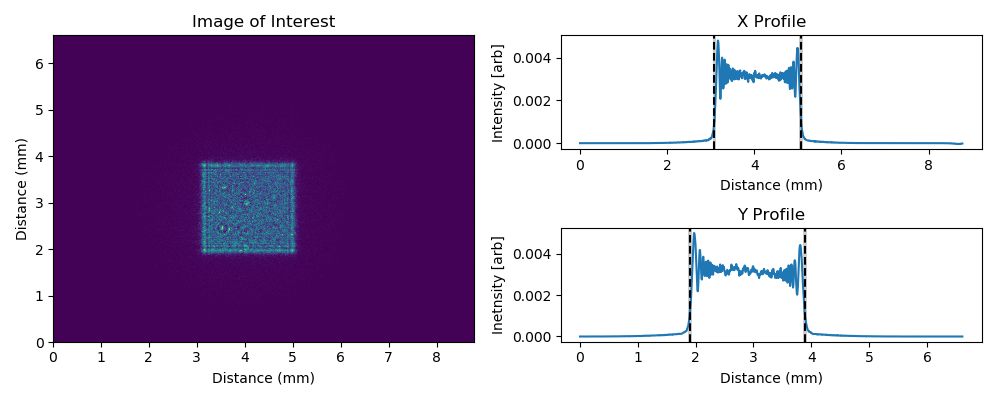

The x width of the square is 1.9866mm
The y width of the square is 1.976925mm


In [51]:
fig = plt.figure(figsize = (10,4))

ax1 = plt.subplot(121)
ax2 = plt.subplot(222)
ax3 = plt.subplot(224)

SQUARE_WIDTH_X_raw, SQUARE_WIDTH_Y_raw, err_S_W_X_raw, err_S_W_Y_raw = plot_image(Image_Raw, ax1, ax2, ax3)

fig.tight_layout()
plt.show()

print('The x width of the square is {}mm'.format(SQUARE_WIDTH_X_raw*1000))
print('The y width of the square is {}mm'.format(SQUARE_WIDTH_Y_raw*1000))

# Plot Filter 1 Image (Just Reconstructed After the Lens)

<IPython.core.display.Javascript object>


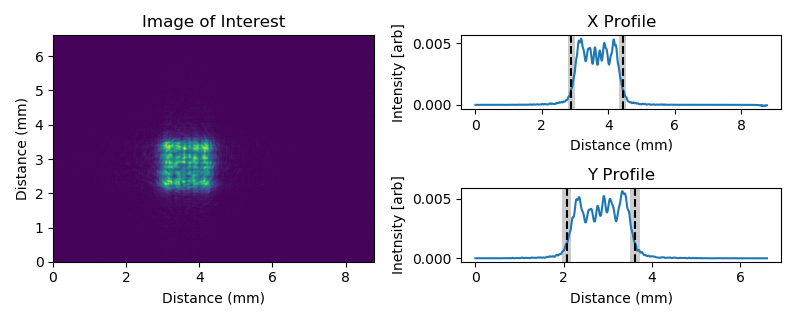

The x width of the square is 1.5480000000000007mm
The y width of the square is 1.5447750000000005mm


In [54]:
fig = plt.figure(figsize = (8,3.2))

ax1 = plt.subplot(121)
ax2 = plt.subplot(222)
ax3 = plt.subplot(224)

SQUARE_WIDTH_X, SQUARE_WIDTH_Y, err_S_W_X, err_S_W_Y = plot_image(Image_Filter_1, ax1, ax2, ax3)

# Magnification
Mx_Filter1 = SQUARE_WIDTH_X/SQUARE_WIDTH_X_raw
My_Filter1 = SQUARE_WIDTH_Y/SQUARE_WIDTH_Y_raw

fig.tight_layout()
plt.savefig('results/pos3nofilter')
plt.show()

print('The x width of the square is {}mm'.format(SQUARE_WIDTH_X*1000))
print('The y width of the square is {}mm'.format(SQUARE_WIDTH_Y*1000))

# Plot Filter 2 Image (Hole in the Fourier Plane)

<IPython.core.display.Javascript object>


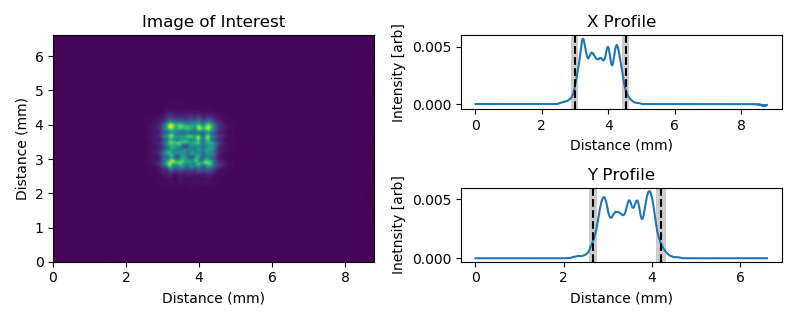

The x width of the square is 1.5318750000000008mm
The y width of the square is 1.5318750000000008mm


In [56]:
fig = plt.figure(figsize = (8,3.2))

ax1 = plt.subplot(121)
ax2 = plt.subplot(222)
ax3 = plt.subplot(224)

SQUARE_WIDTH_X, SQUARE_WIDTH_Y, err_S_W_X, err_S_W_Y = plot_image(Image_Filter_2, ax1, ax2, ax3)

# Magnification
Mx_Filter2 = SQUARE_WIDTH_X/SQUARE_WIDTH_X_raw
My_Filter2 = SQUARE_WIDTH_Y/SQUARE_WIDTH_Y_raw

fig.tight_layout()
plt.savefig('results/pos3filter')
plt.show()

print('The x width of the square is {}mm'.format(SQUARE_WIDTH_X*1000))
print('The y width of the square is {}mm'.format(SQUARE_WIDTH_Y*1000))

# Simulate Fourier Transform on Image

In [43]:
Fourier_Raw_Simulate = simulate_Fourier_2d(Image_Raw)
Fourier_Filter_1_Simulate = simulate_Fourier_2d(Image_Filter_1)
Fourier_Filter_2_Simulate = simulate_Fourier_2d(Image_Filter_2)

# Open Actual Fourier Transform on Image

In [44]:
Fourier_Raw_Actual = image_to_array(directory+"/Fourier_Raw(sat).bmp")
Fourier_Filter_1_Actual = image_to_array(directory+"/Fourier_Filter_1(sat).bmp")
Fourier_Filter_2_Actual = image_to_array(directory+"/Fourier_Filter_2(sat).bmp")

# Plot Comparison of Simulated Frequencies

The plot_raw_filter_comparison renormalizes all the squares to be of the same size so that the frequency domain corresponds to the same thing for all three lines.

<IPython.core.display.Javascript object>


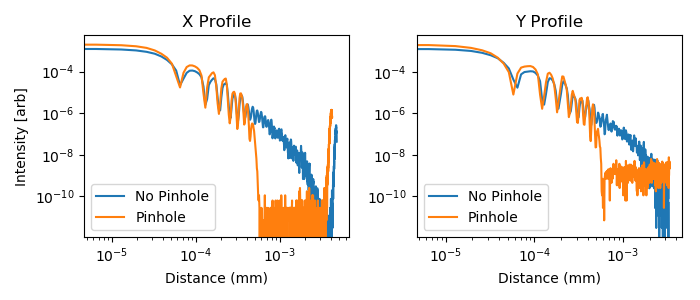

In [115]:
fig, axes = plt.subplots(1, 2, figsize = (7,3))

plot_raw_filter_comparison(axes[0], axes[1], Fourier_Filter_1_Actual, Fourier_Filter_2_Actual)

fig.tight_layout()
plt.savefig('results/positionpwrpsec')

In [68]:
fx1, Gx1, fy1, Gy1 = power_spectral_2d(Image_Filter_1)
fx2, Gx2, fy2, Gy2 = power_spectral_2d(Image_Filter_2)

<IPython.core.display.Javascript object>


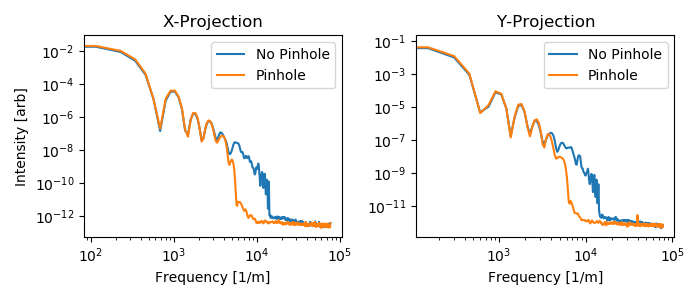

In [99]:
fig, axes = plt.subplots(1,2, figsize=(7,3))

axes[0].loglog(fx1, Gx1, label='No Pinhole')
axes[0].loglog(fx2, Gx2, label='Pinhole')
axes[0].set_title('X-Projection')
axes[0].set_ylabel('Intensity [arb]')
axes[0].set_xlabel('Frequency [1/m]')
axes[0].legend(loc='best')

axes[1].loglog(fy1, Gy1, label='No Pinhole')
axes[1].loglog(fy2, Gy2, label='Pinhole')
axes[1].set_title('Y-Projection')
axes[1].legend(loc='best')
axes[1].set_xlabel('Frequency [1/m]')

fig.tight_layout()
plt.savefig('results/pwrspec')
plt.show()

In [101]:
x =  np.array([1,2,3,4,5,6,])